In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
#read data, and generate basic info
unclean = pd.read_csv('../../UM.csv').copy()
print(unclean.head())
print(unclean.shape)
print(unclean.info())

   Number          Primary UMSCUMCC  Age_at_dx     Sex Durationofsymptoms  \
0   13544  First incidence     UMMC         39  female                  1   
1   13001  First incidence     SDMC         33  female                  8   
2   10450  First incidence     UMMC         60  female                0.5   
3   28149  First incidence     UMMC         66  female                  1   
4   26091  First incidence     UMMC         49  female                NaN   

  Marital_status  Age_at_first_child_birth          Meno_stat famhist  \
0        married                      26.0                NaN      no   
1        married                      32.0       Premenopause      no   
2    not married                       NaN  Natural menopause      no   
3        married                      27.0  Natural menopause      no   
4            NaN                       NaN       Premenopause      no   

               ...               Chemotherapy                  Regime  \
0              ...       

In [3]:
#dropna values and select the columns we want - I have removed the columns that do not apply and the ones with too many missing values


clean = unclean[['Primary','UMSCUMCC','Age_at_dx','Sex','Marital_status','Meno_stat','famhist','Nationality','Race','diagnosis','Classification','Laterality','STAGEAJCC6','Differentiation','ER_status','PR_status','CERB2_status','Pri_Rx','Surgery_type','Axill_dissect','Radiotherapy','Chemotherapy','Event','Durationofsymptoms']].dropna()
clean = clean[(clean['Event']=='Dead') | (clean['Event']=='Alive')]
clean.shape


(2559, 24)

In [4]:

#get rid of 'unknown in the two affected columns:'
clean['ER_status'].replace('unknown',np.NaN)
clean['PR_status'].replace('unknown',np.NaN)
clean.dropna()
clean.Event.value_counts()

Alive    2078
Dead      481
Name: Event, dtype: int64

In [5]:
#go through and change each category name in each column to a number, then make the column categorical data
category_columns = ['Primary','UMSCUMCC','Sex','Marital_status','Meno_stat','famhist','Nationality','Race','diagnosis','Classification','Laterality','STAGEAJCC6','Differentiation','ER_status','PR_status','CERB2_status','Pri_Rx','Surgery_type','Axill_dissect','Radiotherapy','Chemotherapy','Event']
for column in category_columns:
    recode = {}
    for index, value in enumerate(clean[column].value_counts().index.tolist()):
        recode[value] = index
    clean[column] = clean[column].map(recode).astype('category')

In [6]:
#check all is categorical and named correctly:
def print_all_values(df):
    for column in df.columns:
        print("--------------------- %s ---------------------" % column)
        print(df[column].value_counts())

print_all_values(clean)


--------------------- Primary ---------------------
0    2552
1       7
Name: Primary, dtype: int64
--------------------- UMSCUMCC ---------------------
0    1281
1     759
2     519
Name: UMSCUMCC, dtype: int64
--------------------- Age_at_dx ---------------------
48    98
56    87
52    87
44    86
46    85
50    84
49    82
45    81
53    80
55    80
47    79
54    79
60    76
43    73
51    73
57    70
42    68
58    66
63    63
59    61
40    61
61    59
62    56
66    56
64    51
41    50
67    49
69    44
65    43
68    40
      ..
74    20
33    19
36    19
76    17
32    15
30    15
75    14
80    12
77    12
31    11
78    10
29    10
79     9
27     6
82     5
25     4
85     4
28     4
87     3
83     3
23     2
24     2
86     2
88     2
81     2
26     1
89     1
92     1
84     1
22     1
Name: Age_at_dx, Length: 69, dtype: int64
--------------------- Sex ---------------------
0    2555
1       4
Name: Sex, dtype: int64
--------------------- Marital_status --------------

In [7]:
#now we get to cleaning the monstrosity that is Durationofsymptoms
clean.rename(columns={"Durationofsymptoms": "Duration"}, inplace = True) #fix shit name
# detect rows that have decimals and change them to years
frac_mask = clean.Duration.str.contains("0\.\d")
fractions = clean.copy().Duration[frac_mask]
fractions = fractions.astype(float)*365
clean.Duration.loc[frac_mask] = fractions.astype(str)

#Making the assumption that numbers 1-3 are days and 4-11 are months:
mask1 = (clean.Duration=='1') | (clean.Duration== '2') | (clean.Duration == '3')
smalls = clean.Duration.loc[mask1]

#getting rid of row with value 2011 since it is obviously mean to be the year:
clean = clean.drop(clean.index[clean.Duration == '2011'])

#multiply by 365 to get the number of days
smalls = smalls.astype(int)*365
smalls = smalls.astype(str)
clean.Duration.loc[mask1] = smalls

#now to clean the months
mask2 = clean.Duration.str.match("^4$|^5$|^6$|^7$|^8$|^9$|^10$|^11$")
bigs = clean.Duration.loc[mask2]
bigs = bigs.astype(int)*30
clean.Duration.loc[mask2] = bigs.astype(str)
clean.Duration.value_counts()


C:\Users\jc243891\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


182.5                                           501
365                                             363
0                                               233
730                                             221
1095                                            203
12                                              202
180                                             141
120                                             105
24                                               56
240                                              49
150                                              42
1 MONTH                                          30
SCREENING                                        29
3 MONTHS                                         23
48                                               23
210                                              23
270                                              21
2 MONTHS                                         20
36                                               18
1 YEAR      

In [8]:
#detect rows with the word 'screen' in them and replace to 0 (as this was detected at screening)
screen_mask = clean.Duration.str.contains("screen",case=False)
clean.Duration.loc[screen_mask] = '0'
clean.Duration.value_counts()

182.5                                      501
365                                        363
0                                          282
730                                        221
1095                                       203
12                                         202
180                                        141
120                                        105
24                                          56
240                                         49
150                                         42
1 MONTH                                     30
3 MONTHS                                    23
48                                          23
210                                         23
270                                         21
2 MONTHS                                    20
36                                          18
1 YEAR                                      16
6 MONTHS                                    15
109.5                                       13
300          

In [9]:
#try and fix everything with months in it
month_mask = clean.Duration.str.contains("month",case=False)
months = clean.Duration.loc[month_mask]
# lets assume that "few" means 2
months[months.str.contains("few",case=False)] = '2'
#get rid of white space
months = months.str.replace(" ", "")
#remove all alphabetical characters, then multiply by 30 and add back to Duration
months = months.str.extract('(\d+)', expand=False)
months = months.astype(int)*30
clean.Duration.loc[month_mask] = months.astype(str)
clean.Duration.value_counts()


182.5                                      501
365                                        363
0                                          282
730                                        221
1095                                       203
12                                         202
180                                        157
120                                        115
24                                          56
240                                         50
150                                         47
60                                          36
30                                          36
90                                          25
210                                         25
270                                         23
48                                          23
36                                          18
1 YEAR                                      16
300                                         13
109.5                                       13
1 WEEK       

In [10]:
#fixing the years sections
years_mask = clean.Duration.str.contains("yr|year",case=False)
years = clean.Duration.loc[years_mask]
years = years.str.replace(" ", "")
#remove alphabetical characters and multiply by 365

years = years.str.extract('(\d+)', expand=False)

years = years.astype(int)*365
clean.Duration.loc[years_mask] = years.astype(str)
#drop all na values
clean = clean.dropna()
clean.Duration.value_counts()

182.5                                      501
365                                        388
0                                          282
730                                        233
1095                                       206
12                                         202
180                                        157
120                                        115
24                                          56
240                                         50
150                                         47
60                                          36
30                                          36
90                                          25
210                                         25
48                                          23
270                                         23
36                                          18
109.5                                       13
300                                         13
1 WEEK                                      10
2 WEEKS      

In [11]:
#Weeks
week_mask = clean.Duration.str.contains("wk|week",case=False)
weeks = clean.Duration.loc[week_mask]
weeks = weeks.str.replace(" ", "")
#remove alphabetical characters and multiply by 7
weeks= weeks.str.extract('(\d+)', expand=False)
weeks = weeks.astype(int)*7
clean.Duration.loc[week_mask] = weeks.astype(str)
clean.Duration.value_counts()




182.5                                      501
365                                        388
0                                          282
730                                        233
1095                                       206
12                                         202
180                                        157
120                                        115
24                                          56
240                                         50
150                                         47
60                                          36
30                                          36
90                                          25
210                                         25
48                                          23
270                                         23
36                                          18
300                                         13
109.5                                       13
14                                          12
7            

In [12]:
#days
day_mask = clean.Duration.str.contains("day",case=False)
days = clean.Duration.loc[day_mask]
days = days.str.replace(" ", "")
#remove alphabetical characters and store back in the DataFrame
days= days.str.extract('(\d+)', expand=False)
clean.Duration.loc[day_mask] = days.astype(str)
clean.Duration.value_counts()

182.5                                      501
365                                        388
0                                          282
730                                        233
1095                                       206
12                                         202
180                                        157
120                                        115
24                                          56
240                                         50
150                                         47
60                                          36
30                                          36
210                                         25
90                                          25
270                                         23
48                                          23
36                                          18
109.5                                       13
300                                         13
14                                          12
7            

In [13]:
#stripping all whitespace and then removing non digit/number values
clean.Duration = clean.Duration.str.replace(" ", "")
final = clean.copy()
final.Duration = pd.to_numeric(final.Duration, errors='coerce')
final = final.dropna()
final.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2547 entries, 1 to 8589
Data columns (total 24 columns):
Primary            2547 non-null category
UMSCUMCC           2547 non-null category
Age_at_dx          2547 non-null int64
Sex                2547 non-null category
Marital_status     2547 non-null category
Meno_stat          2547 non-null category
famhist            2547 non-null category
Nationality        2547 non-null category
Race               2547 non-null category
diagnosis          2547 non-null category
Classification     2547 non-null category
Laterality         2547 non-null category
STAGEAJCC6         2547 non-null category
Differentiation    2547 non-null category
ER_status          2547 non-null category
PR_status          2547 non-null category
CERB2_status       2547 non-null category
Pri_Rx             2547 non-null category
Surgery_type       2547 non-null category
Axill_dissect      2547 non-null category
Radiotherapy       2547 non-null category
Chemotherapy  

Text(0,0.5,'No. of Patients')

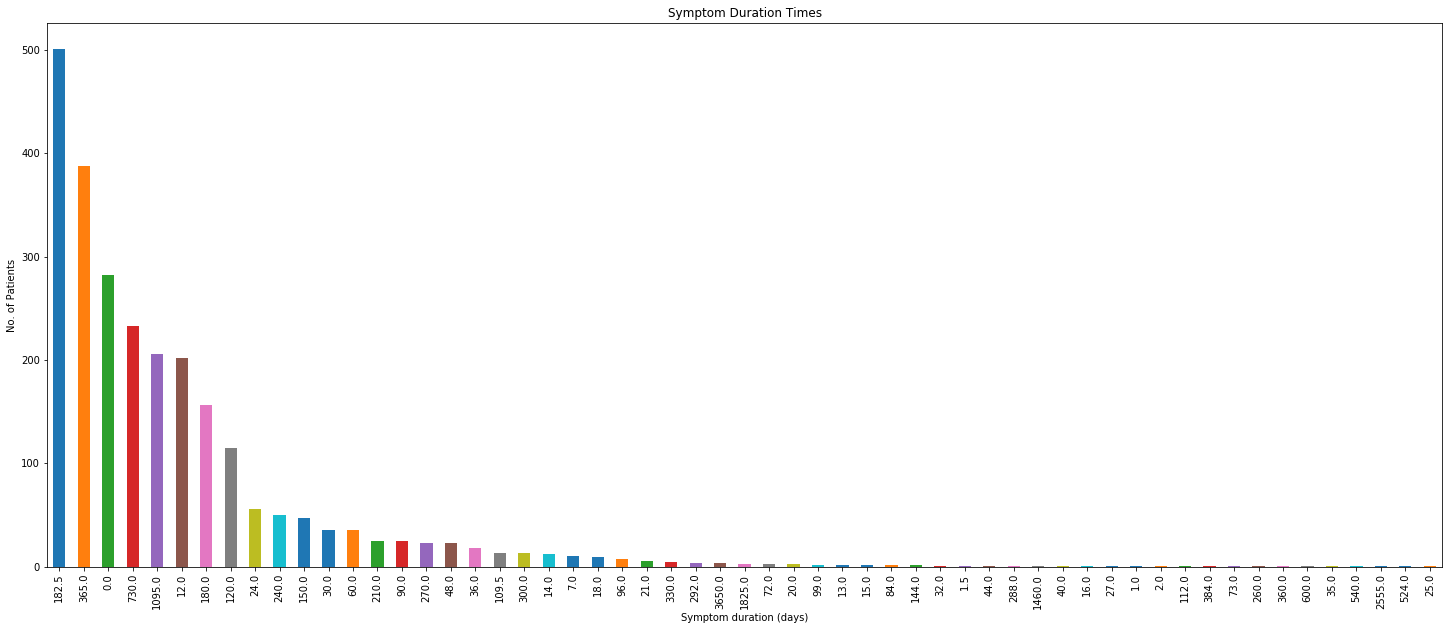

In [14]:
# visual representation of final.Duration.value_counts()
duration_hist = final.Duration.value_counts().plot.bar(figsize=(25,10)) #most people tend to have symptoms of BC for 1/2,1 and 0 yrs.
#interesting that a fair few are at 0 - does this mean that most cases are picked up via screening and show no signs otherwise
duration_hist.set_title('Symptom Duration Times')
duration_hist.set_xlabel('Symptom duration (days)')
duration_hist.set_ylabel('No. of Patients')

In [15]:
final.Duration.describe()

count    2547.000000
mean      294.530232
std       347.962187
min         0.000000
25%        36.000000
50%       182.500000
75%       365.000000
max      3650.000000
Name: Duration, dtype: float64

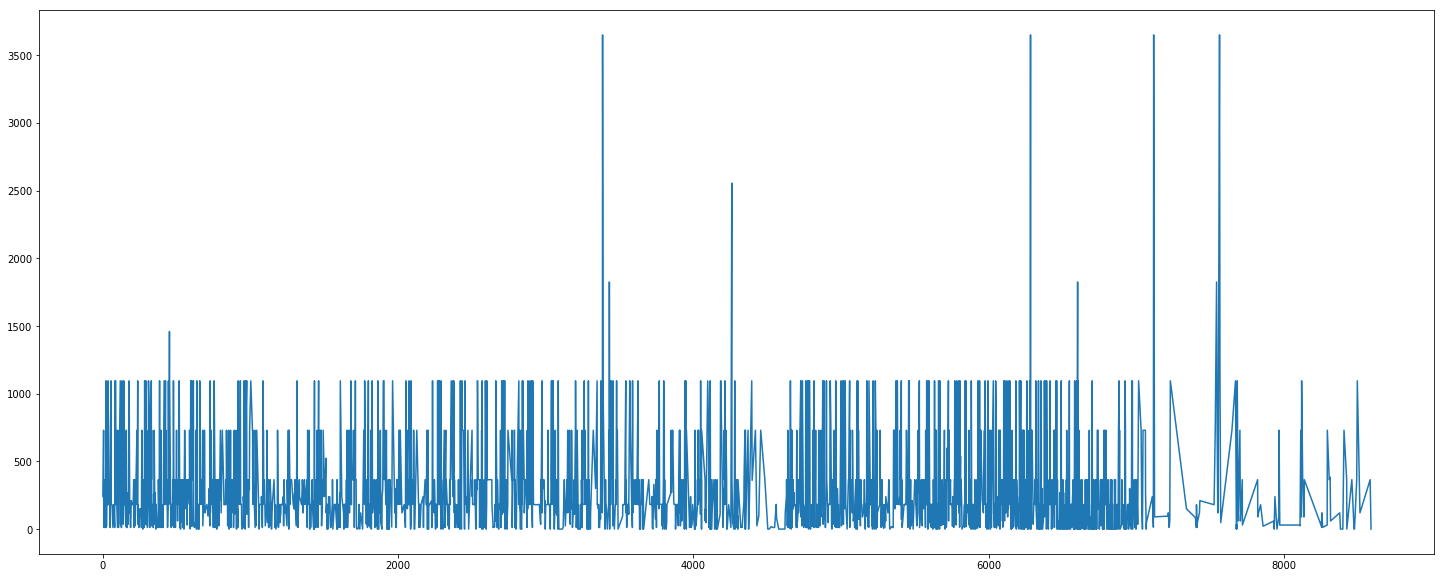

In [19]:
final.Duration.plot(figsize=(25,10)) #simple plot to look at the outliers etc.


In [17]:
#all looks good, so time to save to a csv file.

final.to_csv('../../clean_cancer_data.csv', sep='\t',encoding='utf-8')
